# Анализ изменения конверсии посетителей интернет магазина (анализ А/В теста)

## Аннотация

В данном проекте анализуруются результаты А/В теста посетителей интернет магазина. Тест проводился в августе 2019 года.

Проект состоит из подготовительной и двух основных частей.

1. В подготовительной части представлен обзор имеющихся данных, проведена предобработка, массивы проверены на корректность разбиения по группам.
<p>
</p>

2. В первой части рассматриваются и приоритизируются гипотезы посредством фреймворков ICE и RICE. Сравниваются результаты по двум алгоритмам приоритизации.
<p>
</p>
3. Во второй части анализируются непосредственно данные А/В теста. 
<p>3.1 Сначала проводится анализ куммулятивных метрик посредством визуализации данных (графики куммулятивных метрик).</p>
<p>3.2 На втором этапе данные рассматриваются на предмет аномальных значений. Посредством расчета перцентиллей вычисляются пороговые значения для нормального среднего чека и нормального количества заказов на посетителя магазина.</p>
<p>3.3 На третьем шаге проводится статистический тест для сравнения среднего чека и среднего количества заказов в двух группах. Тесты проводятся как на сырых данных, так и после исключения аномальных значений (посетителей с аномальным количеством заказов и со сверх-дорогими заказами).</p>
<p>Статистический тест делается 2 раза: до удаления пересекающихся в двух группах посетителей и после удаления таковых.</p>
<p>
</p>
4. В заключении делаются выводы о результатах теста в целом.



# Подготовка к работе. Предобработка данных

In [1]:
#загружаем библиотеки
import pandas as pd
import os
import numpy as np
import scipy
from scipy import stats 
import math as mth
import matplotlib.pyplot as plt

In [5]:
#загружаем данные
hypothesis = pd.read_csv('/Users/daria.oreshina/Documents/Практикум/project_7/hypothesis.csv')
orders = pd.read_csv('/Users/daria.oreshina/Documents/Практикум/project_7/orders.csv')
visitors = pd.read_csv('/Users/daria.oreshina/Documents/Практикум/project_7/visitors.csv')

## Предобработка данных

In [6]:
#настроим вид таблиц
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [7]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [8]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
# в таблицах 'orders' и 'visitors' дата представлена в формате object
#приведем данные к формату datetime
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [13]:
#проверим таблицы на наличие полных дубликатов
orders.duplicated().sum()

0

In [14]:
#проверим таблицы на наличие полных дубликатов
visitors.duplicated().sum()

0

### Проверяем корректность разбиения групп теста

In [15]:
# проверим количество посетителй для групп А и В

visitors_groups_num = visitors.groupby('group').agg({'visitors':'sum'})
visitors_groups_num

,visitors
group,
A,18736
B,18916


In [16]:
#посчитаем процент, на который различаются группы
diff1 = visitors_groups_num.loc['B','visitors'] - visitors_groups_num.loc['A','visitors']
diff = round((visitors_groups_num.loc['B','visitors'] - visitors_groups_num.loc['A','visitors'])/visitors_groups_num.loc['B','visitors']*100)

f'В группе В на {diff1} посетителей большей, чем в группе А; это менее {diff}% от каждой из групп, можем игнорировать такую разницу' 

'В группе В на 180 посетителей большей, чем в группе А; это менее 1% от каждой из групп, можем игнорировать такую разницу'

In [17]:
#посчитаем количество посетителей, сделавших заказы, в разрезе по группам
orders_groups_num = orders.groupby('group').agg({'transactionId': 'nunique', 'visitorId': 'nunique'})
orders_groups_num

,transactionId,visitorId
group,,
A,557,503
B,640,586


In [18]:
orders['transactionId'].duplicated().sum()

0

In [19]:
orders['visitorId'].duplicated().sum()

166

In [22]:
dup = round(orders['visitorId'].duplicated().sum()/len(orders['visitorId'])*100)
dup

14

##### Комментарий: 
- количество попкупок в двух группах различается (это нормально), при этом это уникальные транзакции, ошибок учета нет;
- количество посетителей в группе А меньше на 83 единицы, при этом насчитывается 166 дубликатов Id покупателей сайта - это 14% всех данных
- проблемы в дубликатах покупателей нет - они могли делать более 1 заказа

In [23]:
#проверим пересечение групп А и В
group_a = orders[orders['group']=='A']['visitorId'].nunique()
group_b = orders[orders['group']=='B']['visitorId'].nunique()
groups_ab = orders['visitorId'].nunique()
ab_sum = group_a+group_b
diff = ab_sum -groups_ab
diff_percent = round(diff/groups_ab*100)

In [24]:
f'В двух группах вместе {groups_ab} уникальных покупателей. Суммирование посчитанных по отдельности уникальных покупателей дает {ab_sum}'

'В двух группах вместе 1031 уникальных покупателей. Суммирование посчитанных по отдельности уникальных покупателей дает 1089'

In [25]:
f'Разница {diff} единиц - это покупатели, которые попали в обе группы. Таковых {diff_percent}% от всех уникальных посетителей и порядка 10% от каждой из групп'

'Разница 58 единиц - это покупатели, которые попали в обе группы. Таковых 6% от всех уникальных посетителей и порядка 10% от каждой из групп'

In [26]:
#найдем список пересекающихся посетителей
unique_a=pd.DataFrame(orders[orders['group']=='A']['visitorId'].unique())
unique_b=pd.DataFrame(orders[orders['group']=='B']['visitorId'].unique())
unique_b.columns = ['id']
unique_a.columns = ['id']

In [27]:
intersection = unique_b.merge(unique_a, on = 'id', how='inner', suffixes = ('b','a'))
len(intersection)

58

Cоздадим массив orders_clean без пересекающихся посетителей, чтобы проверить результаты теста на нем

In [29]:
#создадим массив orders_clean без пересекающихся посетителей, чтобы проверить результаты теста на нем
orders_clean = orders[~orders['visitorId'].isin(intersection['id'])]
orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


In [30]:
#посмотрим распределение покупателей по группам в массиве orders_clean
orders_clean_groups = orders_clean.groupby('group').agg({'transactionId': 'nunique', 'visitorId': 'nunique'})
orders_clean_groups

,transactionId,visitorId
group,,
A,468,445
B,548,528


In [31]:
#проверим пересечение групп А и В
group_2a = orders_clean[orders_clean['group']=='A']['visitorId'].nunique()
group_2b = orders_clean[orders_clean['group']=='B']['visitorId'].nunique()
groups_2ab = orders_clean['visitorId'].nunique()
ab2_sum = group_2a+group_2b
diff2 = ab2_sum -groups_2ab

In [32]:
(f'Разница между суммой уникальных покупателей в выборке в целом и суммой уникальных покупателей для каждой из групп по отдельности {diff2}. Это значит, пересекающихся покупателей в массиве нет')

'Разница между суммой уникальных покупателей в выборке в целом и суммой уникальных покупателей для каждой из групп по отдельности 0. Это значит, пересекающихся покупателей в массиве нет'

## Выводы
- мы ознакомились с данными для анализа
- провели проверку на наличие явных дубликатов (дубликатов не обнаружено)
- данные приведены к нужному типу (в частности - дата)
- проверили корректность разбиения на группы: в таблице visitors разиение корректное, разница групп по наполненности(количеству посетителей) составляет 1%
- в таблице orders обнаружилось пересечение между группами: 6% уникальных покупателей пошли и в группу А и группу В одновременно; доля пересекающихся посетителей в каждой группе - порядка 10%;
- возможно влияние такого пересечния на результаты теста;
- принято решение провести два варианта теста: с учетом пересечения групп и после удаления пользователей, которые попали в обе группы

# ЧАСТЬ 1. Приоритизация гипотез

## Приоритизация гипотез посредством фреймворка ICE

In [33]:
hypothesis['ice'] = round (hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts'], 2)

In [34]:
#добавим ранг гипотезы
hypothesis['ice_rank'] = hypothesis['ice'].rank(ascending = False)

In [35]:
hypothesis[['Hypothesis','ice', 'ice_rank']].sort_values('ice', ascending = False)

,Hypothesis,ice,ice_rank
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,1.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,2.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,3.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,5.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,6.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,7.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,8.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,9.0


## Приоритизация гипотез посредством фреймворка RICE

In [36]:
hypothesis['rice'] = round (hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts'], 2)

In [37]:
hypothesis['rice_rank'] = hypothesis['rice'].rank(ascending = False)

In [38]:
hypothesis[['Hypothesis','ice', 'ice_rank', 'rice', 'rice_rank']].sort_values('rice', ascending = False)

,Hypothesis,ice,ice_rank,rice,rice_rank
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,3.0,112.0,1.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,5.0,56.0,2.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,2.0,40.0,3.5
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,4.0,40.0,3.5
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,1.0,16.2,5.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,8.0,9.0,6.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,6.0,4.0,7.5
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,7.0,4.0,7.5
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,9.0,3.0,9.0


In [39]:
hypothesis[['Hypothesis', 'rice_rank', 'ice_rank']].sort_values('rice_rank')

,Hypothesis,rice_rank,ice_rank
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",1.0,3.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",2.0,5.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3.5,2.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",3.5,4.0
8,"Запустить акцию, дающую скидку на товар в день рождения",5.0,1.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",6.0,8.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",7.5,6.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",7.5,7.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",9.0,9.0


## Выводы

Приоритизация гипотез двумя алгоритмами дала разные результаты: 
- применение алгоритма rice (с учетом параметра 'reach') поставило на первое место гипотезы №7 и №2(номера гипотез по индексу);
-  в результате ice-алгоритма на первых местах стояли гипотезы №8 и №0. 
- учет параметра 'reach' вывел на первое место предложение "Добавить форму подписки на все основные страницы...", которая, как ожидается, даст бОльший эффект, так как охватит всех посетителей магазина;
- предложение "Запустить акцию, дающую скидку на товар в день рождения" (первое место по ICE-алгоритму), скорее всего, охватит лишь узкий сегмент посетителей магазина (хотя, возможно, и с хорошим эффектом), а потому суммарный эффект от такого нововведения ожидается ниже.

# ЧАСТЬ 2. Анализ А/В теста

## Cоздадим массив с куммулятивными данными

In [51]:
dates_groups = orders_clean[['date', 'group']].drop_duplicates()

In [52]:
orders_aggregated = (dates_groups.apply(lambda x: orders_clean[np.logical_and(orders_clean['date'] <= x['date'],
                                                orders_clean['group'] == x['group'])]
                    .agg({'date':'max', 'group':'max', 'revenue':'sum', 'transactionId':pd.Series.nunique, 'visitorId':pd.Series.nunique}),
                                        axis=1).sort_values(by=['date', 'group'])
                                                                       )

In [53]:
orders_aggregated.head()

,date,group,revenue,transactionId,visitorId
55,2019-08-01,A,142779,23,19
66,2019-08-01,B,59758,17,17
175,2019-08-02,A,234381,42,36
173,2019-08-02,B,221801,40,39
291,2019-08-03,A,346854,66,60


In [54]:
visitors_aggregated = (dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                                           visitors['group']== x['group'])]
                                         .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis = 1)
                                        .sort_values(by = ['date', 'group'])
)

In [55]:
visitors_aggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [56]:
cummulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on = ['date', 'group'])
cummulative_data.columns = ['date', 'group', 'revenue', 'orders', 'buyers', 'visitors']

In [57]:
#сразу посчитаем куммулятивное среднее количество заказов на посетителя
cummulative_data['conversion'] = cummulative_data['orders'] / cummulative_data['visitors']

In [58]:
cummulative_data.head()

,date,group,revenue,orders,buyers,visitors,conversion
0,2019-08-01,A,142779,23,19,719,0.031989
1,2019-08-01,B,59758,17,17,713,0.023843
2,2019-08-02,A,234381,42,36,1338,0.031390
3,2019-08-02,B,221801,40,39,1294,0.030912
4,2019-08-03,A,346854,66,60,1845,0.035772


## График кумулятивной выручки по группам

In [59]:
#создаем таблицу с куммулятивными метриками для группы А
cumm_metric_a = cummulative_data [cummulative_data['group'] == 'A'][['date', 'revenue', 'orders', 'conversion']]

In [60]:
#создаем таблицу с куммулятивными метриками для группы B
cumm_metric_b = cummulative_data [cummulative_data['group'] == 'B'][['date', 'revenue', 'orders', 'conversion']]

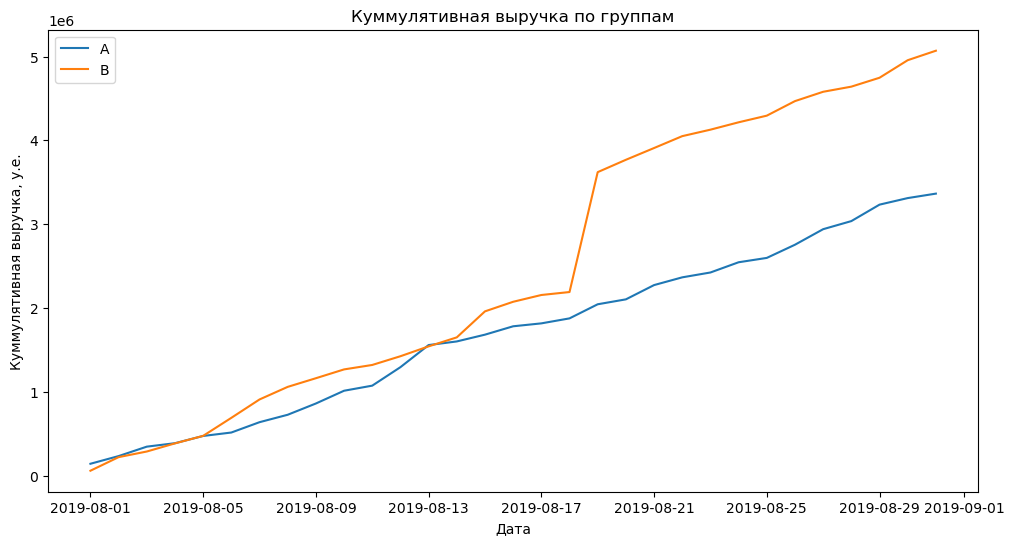

In [61]:
#строим графики
plt.figure(figsize = (12, 6))
plt.plot(cumm_metric_a['date'], cumm_metric_a['revenue'], label = 'A')
plt.plot(cumm_metric_b['date'], cumm_metric_b['revenue'], label = 'B')
plt.legend()
plt.title('Куммулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Куммулятивная выручка, у.е.')
plt.show()

### Выводы: 
- в обеих группа куммулятивная выручка равномерно росла в течение всего периода
- уже на первой неделе теста куммулятивная выручка в группе В была несколько выше, нежели в группе А
- на третьей неделе наблюдается резкий скачок выручки в группе В, вероятно - это может быть связано с аномально-высокими значениями в данных (выбросами)

## Постройте график кумулятивного среднего чека по группам

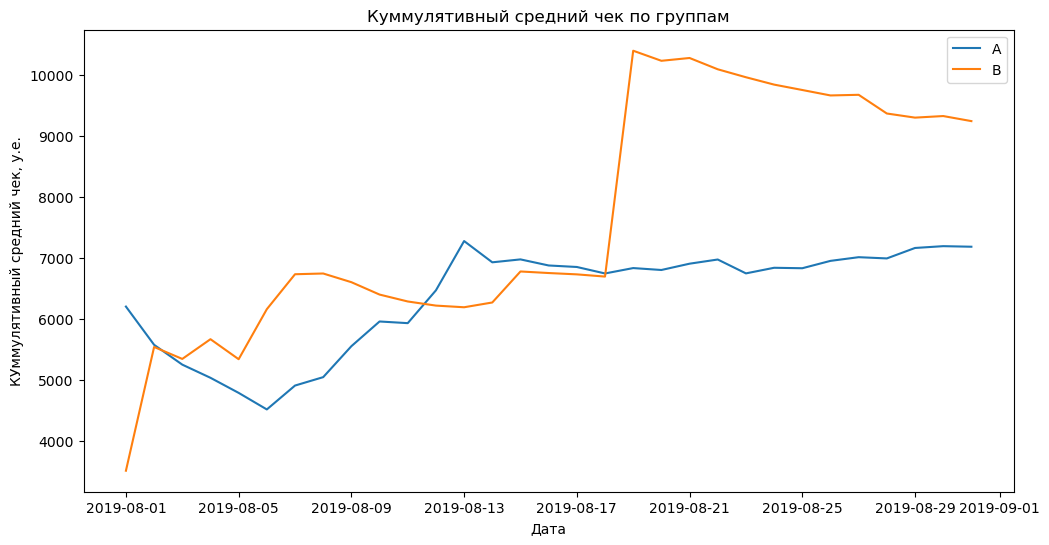

In [62]:
plt.figure(figsize = (12, 6))
plt.plot(cumm_metric_a['date'], cumm_metric_a['revenue']/cumm_metric_a['orders'], label = 'A')
plt.plot(cumm_metric_b['date'], cumm_metric_b['revenue']/cumm_metric_b['orders'], label = 'B')
plt.legend()
plt.title('Куммулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('КУммулятивный средний чек, у.е.')
plt.show()

### Выводы: 
- в обеих группа куммулятивный средний чек в течение всего периода рос, однако неравномерно,  со скачками
- помимо аномального скачка среднего чека в группе В на третьей неделе, видны колебания на первой неделе в обеимх группах; скорее всего есть аномальные значения как в данные по выручке, так и в данных о количестве заказов на человека;
- к концу теста данные о среднем чеке остаются неравномерными; оценивать разницу между группами по такому графику сложно; будем смотреть на аномалии.

## График относительного изменения кумулятивного среднего чека группы B к группе A

In [63]:
#соберем необъходимые метрики в одной таблице
merged_cumm_metric = cumm_metric_a.merge(cumm_metric_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


In [64]:
merged_cumm_metric.head()

,date,revenueA,ordersA,conversionA,revenueB,ordersB,conversionB
0,2019-08-01,142779,23,0.031989,59758,17,0.023843
1,2019-08-02,234381,42,0.031390,221801,40,0.030912
2,2019-08-03,346854,66,0.035772,288850,54,0.029950
3,2019-08-04,388030,77,0.030055,385740,68,0.026428
4,2019-08-05,474413,99,0.029837,475648,89,0.027134


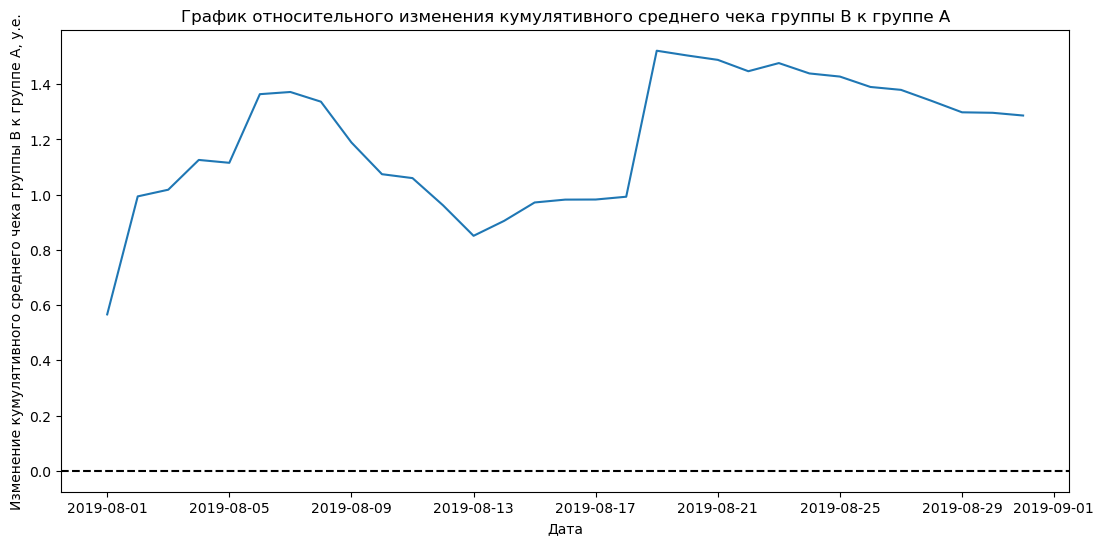

In [65]:
plt.figure(figsize = (13, 6))
plt.plot(merged_cumm_metric['date'], 
          ((merged_cumm_metric['revenueB']/merged_cumm_metric['ordersB'])/
           (merged_cumm_metric['revenueA']/merged_cumm_metric['ordersA'] - 1))
         )
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение кумулятивного среднего чека группы B к группе A, у.е.')

plt.show()

### Выводы: 
- куммулятивный средний чек в группе В стабильно выше чека в группе А;  
- разница между двумя группами неравномерная; очевидно на график влияют аномальные значения

## График кумулятивного среднего количества заказов на посетителя по группам

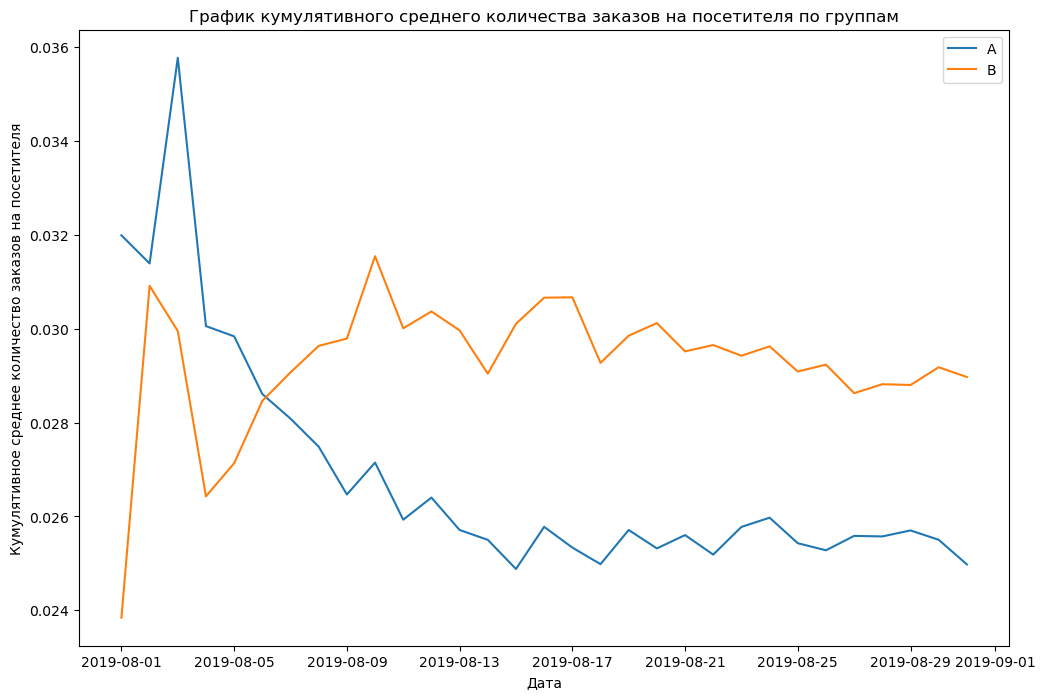

In [66]:
plt.figure(figsize = (12, 8))
plt.plot(cumm_metric_a['date'], cumm_metric_a['conversion'], label = 'A')
plt.plot(cumm_metric_b['date'], cumm_metric_b['conversion'], label = 'B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее количество заказов на посетителя')
plt.legend()
plt.show()

### Вывод: 
- конверсия в группе В стабильно выше конверсии в группе А;
- оба графика неравномерные, требуется анализ аномалий.

## График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

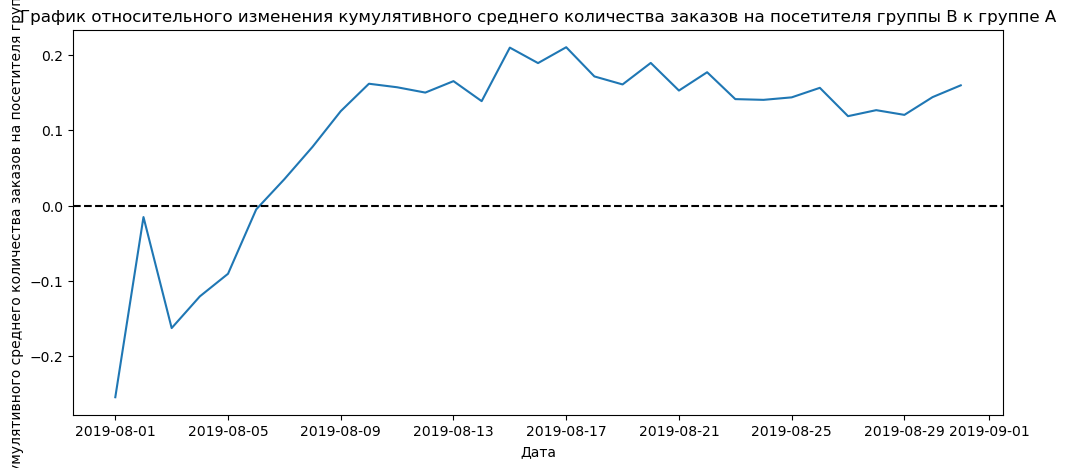

In [67]:
plt.figure(figsize = (12, 5))
plt.plot(merged_cumm_metric['date'], 
          merged_cumm_metric['conversionB']/
           merged_cumm_metric['conversionA'] - 1
         )
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')

plt.show()

### Вывод: 
- на первой неделе теста группа В давала конверсию ниже группы А;
- начиная со второй недели конверсия в группе В стабильно выше;
- график нестабилен весь период: в начале третьей недели опять происходит небольшой спад показателя, потом начинается рост.

## Статистический тест 

### Определение аномального  количества заказов 

In [70]:
orders_clean_grouped = orders_clean.groupby('visitorId').agg({'transactionId':'count'}).reset_index()
orders_clean_grouped.columns = ['visitor_id','orders_number']
orders_clean_grouped.sort_values('orders_number', ascending = False)

,visitor_id,orders_number
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
...,...,...
331,1438226485,1
332,1452540367,1
333,1455323168,1
334,1455861274,1


In [71]:
print(np.percentile(orders_clean_grouped['orders_number'], [95, 99])) 

[1. 2.]


#### Аномальные посетители - это те, кто оформил 2 и более заказов
Больше 1 заказа делают 5% посетителей; более двух заказов делают менее 1% пользователей.
Будем считать пользователей, которые сделали 2+ заказов аномальными. 

### Определение аномальной стоимости заказов 

In [72]:
print(np.percentile(orders_clean['revenue'], (95,99)))

[26785. 53904.]


#### Аномальные заказы - дороже 26 тыс.
Менее 5% заказов имеют стоимость выше 26,8 тыс. у.е., 1% или менее заказов - дороже 53,9 тыс. у.е.
Будем считать заказы дороже 26 000 у.е. аномальными.

### Подготовка данных для теста

In [76]:
#число посетителей на конкретную дату в каждой группе - ничего не пересчитываем, так как массив visitors мы не чистим

In [75]:
#число посетителей на конкретную дату в каждой группе
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']


In [76]:
#число заказов на конкретную дату в каждой группе
orders_daily_a2 = (
    orders_clean[orders_clean['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a2.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_daily_b2 = (
    orders_clean[orders_clean['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b2.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

In [78]:
#формируем таблицу для статистических тестов до среза по аномальным значениям

data_raw2 = (
    orders_daily_a2.merge(
        orders_daily_b2, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
)
data_raw2.head(3)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,visitors_per_date_a,visitors_per_date_b
0,2019-08-01,23,142779,17,59758,719,713
1,2019-08-02,19,91602,23,162043,619,581
2,2019-08-03,24,112473,14,67049,507,509


### Проверка значимости различий в среднем количестве заказов и в среднем чеке заказа на посетителя  

- Создадим список посетителей магазина, заказы которых искажают данные: которые оформили <b>более 1 заказа</b> или сделали заказы <b>дороже 26,8 тыс. у.е.</b>
- Таковых оказалось 98 посетителей

In [79]:
#создаем подвыборку с количеством заказов на 1 посетителя в группе А и В
orders_per_visitor_a2 = orders_clean[orders_clean['group']=='A'].groupby('visitorId', as_index= False).agg({'transactionId':'nunique'})
orders_per_visitor_a2.columns = ['visitors', 'orders']

orders_per_visitor_b2 = orders_clean[orders_clean['group']=='B'].groupby('visitorId', as_index= False).agg({'transactionId':'nunique'})
orders_per_visitor_b2.columns = ['visitors', 'orders']

In [80]:
orders_lim = np.percentile(orders_clean_grouped['orders_number'], (95))
revenue_lim = np.percentile(orders_clean['revenue'], (95))

In [81]:
visitors_many_orders2 = pd.concat(
    [
        orders_per_visitor_a2[orders_per_visitor_a2['orders'] > orders_lim]['visitors'],
        orders_per_visitor_b2[orders_per_visitor_b2['orders'] > orders_lim]['visitors'],
    ],
    axis=0,
)

visitors_exp_orders2 = orders[orders['revenue'] > revenue_lim]['visitorId']

abnormal_visitors2 = (
    pd.concat([visitors_many_orders2, visitors_exp_orders2], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_visitors2.head(5))
print(abnormal_visitors2.shape[0]) 

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
98


#### ТЕСТ 2.1: сравнение количества заказов по группам А/В

<p><b>Гипотезы:</b></p>
<p>H0: Различий в среднем количестве заказов между группами нет.</p>
H1: (Альтернативная) Различия в среднем количестве заказов между группами есть.

In [82]:
# подготовим 2 выборки для проведения теста на очищенных данных

sample_a_filtered2 = pd.concat(
    [
        orders_per_visitor_a2[
            np.logical_not(orders_per_visitor_a2['visitors'].isin(abnormal_visitors2))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_raw2['visitors_per_date_a'].sum() - len(orders_per_visitor_a2['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered2= pd.concat(
    [
        orders_per_visitor_b2[
            np.logical_not(orders_per_visitor_b2['visitors'].isin(abnormal_visitors2))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data_raw2['visitors_per_date_b'].sum() - len(orders_per_visitor_b2['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


In [104]:
print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered2, sample_b_filtered2)[1]))
print('Относительный выигрыш:','{0:.3f}%'.format((sample_b_filtered2.mean()/sample_a_filtered2.mean()-1)*100))

p-value: 0.016
Относительный выигрыш: 17.393%


##### Вывод:
- p-value = 0,016 < 0,05, значит отвергаем нулевую гипотезу; разница в количестве заказов в группах А и В статистически значима (p-value еще ниже, чем на данных до удаления пересекающихся пользователей);
- относительный выигрыш группы В - 17,4%, что еще выше, чем на данных до удаления пересекающихся посетителей;
- делаем вывод, что количество заказов в группе В больше.


#### ТЕСТ 2.2: средний чек в группах А/В
<p><b>Гипотезы </b></p>
<p>H0: Различий в среднем чеке заказа на посетителя  между группами нет.</p>
H1: (Альтернативная) различия в среднем чеке заказа на посетителя между группами есть.

In [103]:
print('p-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders_clean[
                np.logical_and(
                    orders_clean['group'] == 'A',
                    np.logical_not(orders_clean['visitorId'].isin(abnormal_visitors2)),
                )
            ]['revenue'],
            orders_clean[
                np.logical_and(
                    orders_clean['group'] == 'B',
                    np.logical_not(orders_clean['visitorId'].isin(abnormal_visitors2)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительный выигрыш:',
    "{0:.3f}%".format(
        (
        orders_clean[
            np.logical_and(
                orders_clean['group'] == 'B',
                np.logical_not(orders_clean['visitorId'].isin(abnormal_visitors2)),
            )
        ]['revenue'].mean()
        / orders_clean[
            np.logical_and(
                orders_clean['group'] == 'A',
                np.logical_not(orders_clean['visitorId'].isin(abnormal_visitors2)),
            )
        ]['revenue'].mean()
        - 1
    )
        *100)
) 


p-value: 0.727
Относительный выигрыш: -3.373%


##### Вывод:
-  группа В проигрывает по средней сумме заказа. наблюдаемый проигрыш -  около 3%;

- p-value = 0,72 > 0,05, значит не отвергаем нулевую гипотезу:  <b>разница в среденем чеке между группами А и В статистически не значима</b>;
- делаем вывод, что посетители магазина из группы В в среднем платили столько же за заказ, что и посетители группы А.

## Общий вывод:

1. Анализ результатов А/В теста позволяет сделать вывод, что:
- в группе В количество заказов выше, чем в группе А на 17,4%; эта разница статистически значима;
- посетители группы В в среднем оставляют столько же денег за заказ, сколько и посетители группы А (нет значимой разницы в среднем чеке между группами)
<p></p>

2. Предлагается остановить тест с результатом, что нововведение (которое тестировалось в рамках теста) привело к увеличению конверсии (количества заказов на посетителя).
<p></p>

3. Для повышения среднего чека заказа рекомендуется тестировать другую гипотезу. 